在本章中，首先，我们会讨论如何对决策树进行训练，可视化和预测；然后介绍sklearn的CART训练算法，讨论如何对决策树进行正则化并将其用于回归任务；最后我们会谈一谈决策树的部分限制。

In [1]:
import numpy as np
import os
# to make this notebook's output stable across runs
np.random.seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 为了显示中文
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 为了显示中文
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

# 训练决策树和可视化

要了解决策树，让我们先构建一个决策树，看看它是如何做出预测的。

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [4]:
# 可视化决策树
from sklearn.tree import export_graphviz

export_graphviz(
        # 决策树
        tree_clf,
        # 保存文件路径
        out_file=image_path("iris_tree.dot"),
        # 特征名字
        feature_names=iris.feature_names[2:],
        # 类别名
        class_names=iris.target_names,
        # 绘制带有圆角的框
        rounded=True,
        # 当设置为“true”时，绘制节点以指示分类、回归极值或节点纯度用于多输出。
        filled=True
    )

需要百度下载安装graphviz，并配置好路径，可以在cmd使用dot命令，然后pip 安装graphviz，可能安不上，需要去下载.whl文件离线安装

In [9]:
import graphviz

with open(image_path("iris_tree.dot")) as f:
    dot_graph = f.read()
dot=graphviz.Source(dot_graph)
dot.view()

'Source.gv.pdf'

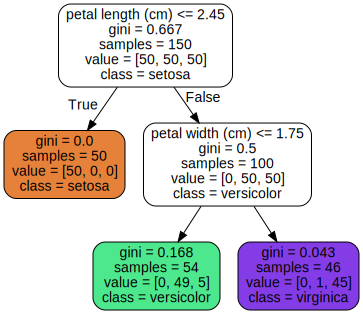

In [10]:
dot

# 做出预测

我们来看看上图是如何做出预测的。如果我们找到了一朵鸢尾花。想要将其归类，那么从根节点(深度为0，位于顶部)开始：这朵花的花瓣长度是否小于2.45cm？如果是，则前往左侧子节点(深度1，左)。在本例中，这是一个叶节点(即没有任何子节点)，所以它不再继续提出问题，我们可以直接查看这个节点的预测类别，也就是说，决策树预测我们的这朵花为setosa鸢尾花。

假设我们又找到一朵花，但是这次的花瓣长度大于2.45cm。我们需要移动到右子节点(深度1，右)，该节点不是叶节点，所以它提出另一个问题：花瓣宽度是否小于1.75cm？如果是，那么这朵花可能是versicolor鸢尾花(深度2，左),如果不是，那就可能是virginica鸢尾花(深度2，右)

决策树的特质之一就是它们需要的数据准备非常少，特别是，完全不需要进行特征缩放或集中。

sample属性统计了它应用的训练实例数量。

gini属性衡量其不纯度：如果应用的所有训练实例都属于同一个类别，那么节点就是纯的(gini=0)，深度2左侧节点的基尼系数为$1-(0/54)^2-(49/54)^2-(5/54)^2=0.168$

<b>基尼不纯度</b>
$$
G_i=-\sum_{k=1}^{n}P_{i,k}^2
$$
$P_{i,k}$是第i个节点上，类别k的训练实例占比

sklearn使用CART算法，该算法仅生成二叉树:非叶节点永远只有两个子节点(即问题的答案只有是和否)。但是其他算法，比如ID3生成的决策树算法，其节点可以拥有两个以上的子节点。

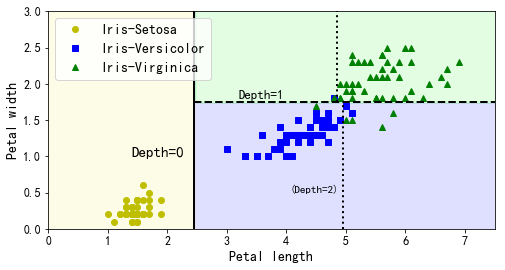

In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    # 打表
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    # 取得图上每一个格子的预测类别
    y_pred = clf.predict(X_new).reshape(x1.shape)
    # 标定每一个类别的颜色
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    # 对每一个格子涂上颜色
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    #  针对不是鸢尾花数据集的时候
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="upper left", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y,legend=True)
# 手动绘制决策边界
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
# 手动打上标签
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)
plt.show()

上图显示了决策树的决策边界。加粗直线表示根节点(深度0)的决策边界：花瓣长度=2.45。因为左侧区是纯的，左移不可再分。但是右侧区域是不纯的，所以深度1右侧的节点在花瓣宽度=1.75cm处再次分裂。因为这里最大深度max_depth=2.所以决策树再次停止。但是如果我们设置为3，那么两个深度为2的节点将各自再产生一条决策边界。

<center><b>模型解释：百盒子与黑盒子</b></center>
如你所见，决策树是非常直观的，它们的决策也很容易解释，这类模型通常被称为百盒模型。与之相反的，我们稍后将会看到，随机森林或是神经网络模型被认为是一种黑盒模型。它们能做出很棒的预测，我们也可以轻松检测它们做出预测时执行的计算。然而，通常很难解释它们为什么做出这样的预测。比如，如果神经网络说某个人出现在一张图片上，很难知道它实际是基于什么做出的该预测：是模型识别出来了这个人的眼睛？嘴巴？鼻子？还是鞋子？甚至 是她坐的沙发？相反，决策树提供了简单好用的分类规则。需要的话，我们甚至可以手动应用这些规则(例如，花的分类)。

# 估算类别概率

决策树同样也可以估算某个实例属于特定类别k的概率：首先，跟随决策树找到该实例的叶节点，然后返回该节点中类别k的训练实例占比。例如，假设我们发现一朵花，其花瓣长5cm，宽1.5cm。相应的叶节点为深度2左侧节点，因此决策树输出如下概率：Setosa鸢尾花，0(0/54),Versicolor鸢尾花90.7%(49/54)Virginica鸢尾花,9.3%(5/54)。

In [17]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

当然，如果我们要求它预测类别，那么它应该输出Versicolor鸢尾花(类别1)

In [18]:
tree_clf.predict([[5, 1.5]])

array([1])

需要注意的是，在矩阵内的任意点的估算概率都相同，比如-花瓣长6cm，宽1.5cm，概率还是一样的，虽然现在看起来，大概率应该是Verginica鸢尾花。

# CART训练算法

Sklearn使用分类与回归树(Classification And Regression Tree 简称CART)算法来训练决策树(也叫做"生长"树)。做法很简单：首先，使用单个特征k和阈值$t_k$（例如，花瓣长度$\leq$2.45cm）将训练集分成两个子集。k和阈值$t_k$怎么选择？答案是产出最纯的子集(受其大小加权)的k和$t_k$就是经算法搜索确定的$(t,t_k)$.

<b>CART分类损失函数</b>
$$
J(k,t_k)=\frac{m_{left}}{m}G_{left}+\frac{m_{right}}{m}G_{right}\\
其中,
\begin{cases} 
G_{left/right}衡量左/右子集的不纯度\\
m_{left/right}是左/右子集的实例数量
\end{cases}
$$

一旦成功将训练集一分为二，他将使用相同的逻辑，继续分裂子集，然后是子集的子集，依次循环递进。直到抵达最大深度(由超参数max_depth控制)，或是再也找不到能够降低不纯度的分裂，它才会停止。当然，还有一些超参数会在之后介绍。

如你所见：CART是一种贪婪算法：从顶层开始搜索最优分裂，然后每层重复这个过程。几层分裂以后，它不会检视这个分裂的不纯度是否为可能的最低值。贪婪算法通常会产生一个相当不错的解，但不能保证是最优解。

而不幸的是，寻找最优树是一个已知的NP完全问题：需要的时间是O(exp(m))，所以即使是很小的训练集，也相当棘手，这就是为什么我们必须接受一个“相当不错”的解。

# 计算复杂度

进行预测需要从根到叶遍历决策树。通常来说，决策树大致平衡，因此遍历决策树需要经历大约$O(\log_2(m))$个节点。而每个节点只需要检查一个特征值，所以总体预测复杂度也只是$O(\log_2(m))$,与特征数量无关。如此，即便是处理大型数据，预测也很快。

但是，训练时在每一个节点，算法都需要在所有样本上比较所有特征(如果设置了max_features会少一点)。这导致训练的复杂度为$O(n\times m(\log(m)))$。对于小型训练集(几千个实例以内),sklearn可以通过对数据进行预处理(设置presort=True)来加快训练，但是对于较大训练集而言，可能会减慢训练的速度。

# 基尼不纯度还是信息熵

默认使用基尼不纯度来进行测量，但是，我们可以将超参数criterion设置为"entropy"来选择信息熵作为不纯度的测量方式。熵的概念源于热力学，是一种分子混乱程度的度量：如果分子保持静止和良序，则熵接近于零。后来这个概念传播到各个领域，其中包括香农的信息理论，它衡量的是一条信息的平均信息内容：如果所有信息都相同，则熵为0.

在机器学习中，它也经常被用作一种不纯度的测量方式：如果数据集中仅包含一个类别的实例，则熵为0.
<br><b>信息熵</b>
$$
H_i=-\sum_{k=1\\P_{i,k}\ne0}^{n}P_{i,k}\log(P_{i,k})
$$
以深度2左侧节点为例：$-\frac{49}{54}\log(\frac{49}{54})-\frac{5}{54}\log(\frac{5}{54})\approx0.31$

那么我们到底该选择基尼不纯度还是信息熵呢？其实，大多数情况下它们并没有什么大的不同，产生的树很相似。基尼不纯度的计算速度略微快一些，所以它是个不错的默认选择。它们的不同在于，基尼不纯度倾向于从树枝中分裂出最常见的类别，而信息熵则倾向于生产更平衡的树。

# 正则化超参数

决策树极少对训练数据做出假设(比如线性模型就正好相反，它显然假设数据是线性的)。如果不加以限制，树的结构就随着训练集变化，严密拟合，并且很可能过拟合。这种模型通常被称为非参数模型，这不是说它不包含任何参数(事实上它通常有很多参数),而是指在训练之前没有确定参数的数量，导致模型结构自由而紧密地贴近数据。相应的参数模型，比如线性模型，择优预先设定好的一部分参数，因此其自由度受限，从而降低了过度拟合的风险(也就是增加了拟合不足的风险)。

为避免过度拟合，我们会选择降低训练过程中决策树的自由度，也就是控制决策树的深度(通过max_depth来控制)。

此外决策树还有其他超参数可以限制决策树的形状：min_samples_split(分裂前节点必须有的最小样本数),min_samples_leaf(叶节点必须有的最小样本数),min_weight_fraction_keaft(跟min_samples_leaf一样，但是表现为加权实例总数的占比),max_leaf_nodes(最大叶节点数量),以及max_features(分裂每个节点评估的最大特征数)。增大超参数min_或是减小max_将使模型正则化。

此外，还可以先不加约束地训练模型，然后再剪枝。

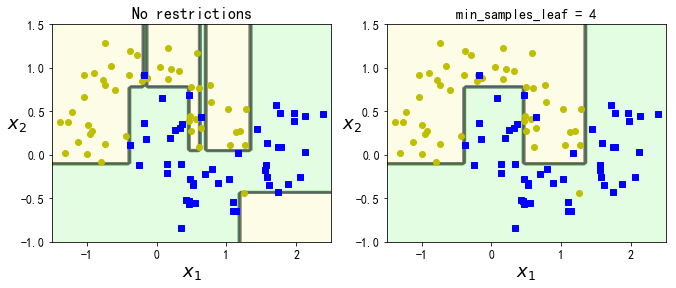

In [26]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

plt.show()

# 回归

决策树也可以执行回归任务。

In [35]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [36]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

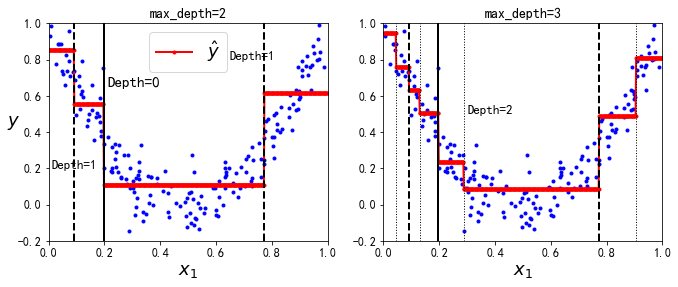

In [37]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

In [43]:
export_graphviz(
        tree_reg1,
        out_file=image_path("regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

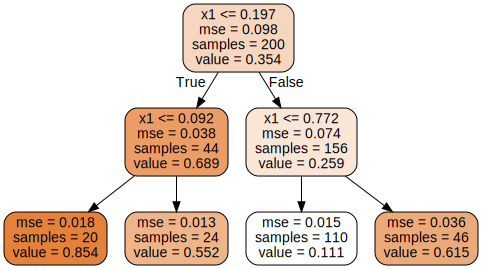

In [44]:
import graphviz

with open(image_path("regression_tree.dot")) as f:
    dot_graph = f.read()
dot=graphviz.Source(dot_graph)
dot

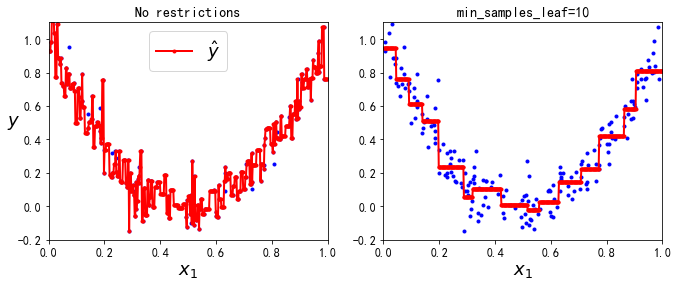

In [45]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

与分类任务一样，决策树在处理回归任务时，也容易过拟合。

# 不稳定性

希望现在，你已经确信了选择决策树的充足理由：他们很容易理解和解释，使用简单，功能全面并且十分强大。但是，它们确实也有一些限制。
1. 首先，决策树青睐正交的决策边界，这导致其在面对训练集的旋转非常敏感。如下面的两个对比。限制这种问题的方法之一是使用PCA，后面介绍。
2. 其次，决策树对训练集的小变化非常敏感。

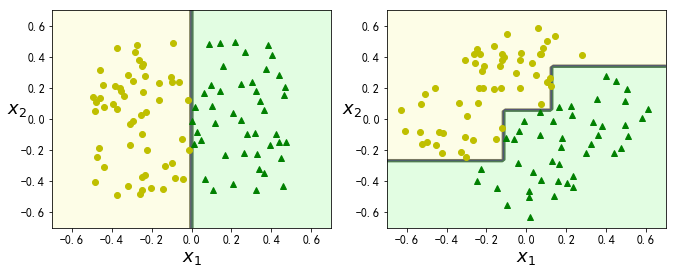

In [34]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

# 旋转角度
angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

plt.show()

In [30]:
# 移除 花瓣长4.8cm 宽1.8的数据 
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris-Versicolor flower

array([[4.8, 1.8]])

In [31]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=40, splitter='best')

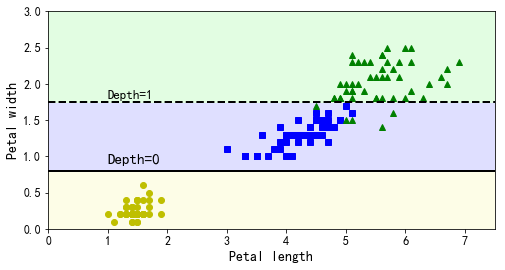

In [32]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

plt.show()

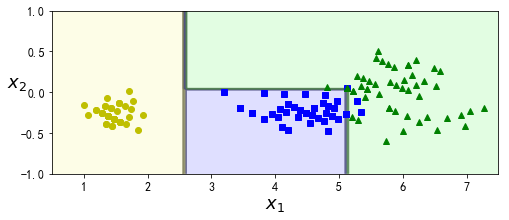

In [33]:
angle = np.pi / 180 * 20
# 对数据进行旋转
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

# 练习

## 7.对月亮数据训练并微调一个决策树

In [46]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:    2.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 

In [49]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=17,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [50]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

## 8.种植一片森林

In [51]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []
# 生成10000个子集，每个子集100个数据
rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [52]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []
# 对1000组数据进行训练和统计准确率
for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

In [53]:
# 统计1000组数据的结果，然后投票
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)
    
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

In [54]:
# 精度比单个树上升了很多
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872